# Filter transmission profiles for COMBO-17

In [1]:
from glob import glob

import numpy as np
from astropy.table import Table as astropy_table
from astropy.io.votable.tree import VOTableFile, Resource, Table, Field, Param

from matplotlib import pyplot as plt
plt.style.use('ggplot')

There are two sources for transmission profiles for COMBO-17:

- The project provides total **efficiency** curves for the filter used on this page 
  http://www.mpia.de/COMBO/combo_filters.html

- The Spanish Virtual Observatory provides the LaSilla/WFI **transmission** curves
  taken from the ESO web page 
  (http://www.eso.org/sci/facilities/lasilla/instruments/wfi/inst.html).
  
The profiles given by SVO/ESO does not seem to take into account the CDD response while the files provided by the project do. For instance, compare the I band provided by ESO (the response table contains only the blue line):

![I band](http://www.ls.eso.org/sci/facilities/lasilla/instruments/wfi/inst/filters/845.gif)

to the one from the COMBO-17 page:

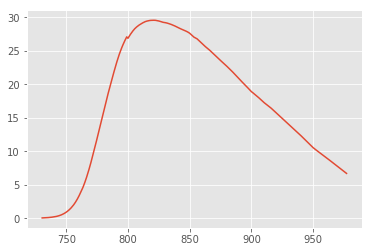

In [2]:
i_band = astropy_table.read("data/combo_filters/epsi_I.fits")
plt.plot(i_band['lamb_I__D'], i_band['epsi_I__D']);

We will then use the files from the COMBO-17 page and convert them to VO-table to be ingested in the HELP filter database.

In [3]:
# Filter and band name were choosen to reflect the names from the ESO/WFI web page.

filter_name = {
    '420m': "wfi_416nm",
    '464m': "wfi_461nm",
    '485m': "wfi_485nm",
    '518m': "wfi_518nm",
    '571m': "wfi_571nm",
    '604m': "wfi_604nm",
    '646m': "wfi_646nm",
    '696m': "wfi_696nm",
    '753m': "wfi_753nm",
    '815m': "wfi_815nm",
    '855m': "wfi_856nm",
    '915m': "wfi_914nm",
    'B': "wfi_b",
    'I': "wfi_i",
    'R': "wfi_r",
    'U': "wfi_u",
    'V': "wfi_v"
}

filter_band_name = {
    '420m': "WFI 416/20",
    '464m': "WFI 461/13",
    '485m': "WFI 485/31",
    '518m': "WFI 518/16",
    '571m': "WFI 571/25",
    '604m': "WFI 604/21",
    '646m': "WFI 646/27",
    '696m': "WFI 696/20",
    '753m': "WFI 753/18",
    '815m': "WFI 815/20",
    '855m': "WFI 856/14",
    '915m': "WFI 914/27",
    'B': "WFI B/99",
    'I': "WFI Ic/Iwp",
    'R': "WFI Rc/162",
    'U': "WFI U/38",
    'V': "WFI V/89"  
}

description = {
    band: "Efficiency of filter {} of the WFI instrument on La Silla telescope. It includes two telescope "
          "mirrors, the CCD detector and an average La Silla atmosphere.".format(filter_band_name[band][4:])
    for band in filter_band_name
}

facility = "La Silla"
instrument = "WFI"

In [4]:
for f in glob("data/combo_filters/*fits"):
    name = f[24:][:-5]
    orig_table = astropy_table.read(f)
    wave, trans = orig_table.columns[0], orig_table.columns[1]
    
    votable = VOTableFile()
    resource = Resource()
    votable.resources.append(resource)
    table = Table(votable)
    resource.tables.append(table)
    
    table.fields.extend([
            Field(votable, name="Wavelength", datatype="float", unit="nm"),
            Field(votable, name="Transmission", datatype="float", unit=""),
        ])
    table.create_arrays(len(wave))

    table.array["Wavelength"] = wave
    table.array["Transmission"] = trans
    
    table.params.extend([
            Param(votable, name="Description", datatype='char', arraysize='*',
                 value=description[name]),
            Param(votable, name="Band", datatype='char', arraysize='*',
                 value=filter_band_name[name]),
            Param(votable, name="Facility", datatype='char', arraysize='*',
                 value="La Silla"),
            Param(votable, name="Instrument", datatype='char', arraysize='*',
                 value="WFI"),
            Param(votable, name="AdditionalProcessing", datatype='char', arraysize='*'),
        ])
        
    table.get_field_by_id("AdditionalProcessing").description = \
        "Efficiency profile taken from the COMBO-17 project - http://www.mpia.de/COMBO/combo_filters.html"
    
    votable.to_xml("data/help_filters/{}.xml".format(filter_name[name]))